In [1]:
def set_paths():

    import os
    import sys

    USECASES_SRC = os.path.join(os.environ.get('BDA_USER_HOME', ''), "repositorios", "use-cases")
    if USECASES_SRC not in sys.path:
        sys.path.append(USECASES_SRC)


set_paths()

In [2]:
from churn_nrt.src.utils.spark_session import get_spark_session

sc, spark, sql_context=get_spark_session(app_name="new_competitor_model_by_nif")

In [3]:
pred_eval=spark.read.load('/data/udf/vf_es/churn/churn_competitor_model/v2/multiclase/pred_20191231_evaluation_NIF')

In [4]:
pred_eval.limit(5).toPandas()

,nif_cliente,prob_array,prediction,label,prediction_multilabel,certainity_1,certainity_2
0,81836875F,"[0.223228438389, 0.239416068597, 0.19770550111...",others,[2],"[others, movistar]",0.100234,1.364246
1,98948904U,"[0.22005027388, 0.345419685659, 0.222994833344...",movistar,"[2, 2]","[movistar, orange]",0.122425,1.367392
2,56419938D,"[0.251318064408, 0.252208204289, 0.27694260942...",orange,[3],"[orange, movistar]",0.024734,1.382942
3,90788209M,"[0.216020280425, 0.297883321593, 0.27340624520...",movistar,[3],"[movistar, orange]",0.024477,1.375558
4,77620623E,"[0.250336631394, 0.233069285666, 0.24645445342...",others,[3],"[others, masmovil]",0.019803,1.384892


In [5]:
from pyspark.sql.functions import (lit, from_unixtime, unix_timestamp,
                                   regexp_replace, split,concat_ws, array,
                                   col, array_contains,collect_list, when)

In [6]:
print('[Info]: Since mode is evaluation, we calculate the accuracy of the model: if the predicted label is contained in the list of real labels for each NIF, we consider the prediction correct')

final_predictions_accuracy = pred_eval.withColumn('real_label_contain_1',
                                                          when(array_contains(col('label'), 1),
                                                               1).otherwise(0)).withColumn('real_label_contain_2',
                                                                   when(array_contains(col('label'), 2),
                                                                        1).otherwise(0)).withColumn('real_label_contain_3',
                                                                   when(array_contains(col('label'), 3),
                                                                        1).otherwise(0)).withColumn('real_label_contain_4',
                                                                   when(array_contains(col('label'), 4),
                                                                        1).otherwise(0))

final_predictions_accuracy = final_predictions_accuracy.withColumn('acierto',
                                                                   when((((col('prediction') == 'masmovil') & (col(
                                                                       'real_label_contain_1') == 1))
                                                                         | ((col('prediction') == 'movistar') & (
                                                                                   col('real_label_contain_2') == 1))
                                                                         | ((col('prediction') == 'orange') & (
                                                                                   col('real_label_contain_3') == 1))
                                                                         | ((col('prediction') == 'others') & (
                                                                                   col('real_label_contain_4') == 1))),1).otherwise(0))



[Info]: Since mode is evaluation, we calculate the accuracy of the model: if the predicted label is contained in the list of real labels for each NIF, we consider the prediction correct


In [7]:
final_predictions_accuracy.limit(5).toPandas()

,nif_cliente,prob_array,prediction,label,prediction_multilabel,certainity_1,certainity_2,real_label_contain_1,real_label_contain_2,real_label_contain_3,real_label_contain_4,acierto
0,81836875F,"[0.223228438389, 0.239416068597, 0.19770550111...",others,[2],"[others, movistar]",0.100234,1.364246,0,1,0,0,0
1,98948904U,"[0.22005027388, 0.345419685659, 0.222994833344...",movistar,"[2, 2]","[movistar, orange]",0.122425,1.367392,0,1,0,0,1
2,56419938D,"[0.251318064408, 0.252208204289, 0.27694260942...",orange,[3],"[orange, movistar]",0.024734,1.382942,0,0,1,0,1
3,90788209M,"[0.216020280425, 0.297883321593, 0.27340624520...",movistar,[3],"[movistar, orange]",0.024477,1.375558,0,0,1,0,0
4,77620623E,"[0.250336631394, 0.233069285666, 0.24645445342...",others,[3],"[others, masmovil]",0.019803,1.384892,0,0,1,0,0


In [ ]:
#Añado acierto multilabel

In [8]:
final_predictions_accuracy = final_predictions_accuracy.withColumn('multi_label_contain_1',
                                                          when(array_contains(col('prediction_multilabel'), 'masmovil'),
                                                               1).otherwise(0)).withColumn('multi_label_contain_2',
                                                                   when(array_contains(col('prediction_multilabel'), 'movistar'),
                                                                        1).otherwise(0)).withColumn('multi_label_contain_3',
                                                                   when(array_contains(col('prediction_multilabel'), 'orange'),
                                                                        1).otherwise(0)).withColumn('multi_label_contain_4',
                                                                   when(array_contains(col('prediction_multilabel'), 'others'),
                                                                        1).otherwise(0))

In [9]:
final_predictions_accuracy = final_predictions_accuracy.withColumn('acierto_multilabel',
                                                                   when((((col('multi_label_contain_1') == 1) & (col(
                                                                       'real_label_contain_1') == 1))
                                                                         | ((col('multi_label_contain_2') == 1) & (
                                                                                   col('real_label_contain_2') == 1))
                                                                         | ((col('multi_label_contain_3') == 1) & (
                                                                                   col('real_label_contain_3') == 1))
                                                                         | ((col('multi_label_contain_4') == 1) & (
                                                                                   col('real_label_contain_4') == 1))),1).otherwise(0))



In [10]:
preds_eval=final_predictions_accuracy

In [29]:
preds_eval.filter(col('real_label_contain_1')==1).count()

19715

In [32]:
preds_eval.filter(col('real_label_contain_2')==1).count()

16846

In [30]:
preds_eval.count()

69811

In [33]:
(float(19715)+ float(16846))/float(69811)

0.5237140278752632

## Accuracy vs certainity

- Saco las predicciones en modo production para esa fecha a nivel NIF.
- Calculo el threshold de certainity que se corresponde a coger cada volumen (de mayor a menor certeza)
- Saco el acierto (como lo hemos calculado aquí) para el threshold obtenido, con las predicciones de evaluation

In [15]:
pred_prod=spark.read.load('/data/attributes/vf_es/model_outputs/model_scores/model_name=churn_competitor/year=2020/month=6/day=-1')

In [16]:
from pyspark.sql.functions import split

In [17]:
split_col = split(pred_prod['model_output'], ';')
pred_prod =pred_prod.withColumn('masmovil', split_col.getItem(0))
pred_prod = pred_prod.withColumn('movistar', split_col.getItem(1))
pred_prod = pred_prod.withColumn('orange', split_col.getItem(2))
pred_prod = pred_prod.withColumn('others', split_col.getItem(3))

In [19]:
from  pyspark.sql.functions import log

pred_prod = pred_prod.withColumn("certainity_2", -(pred_prod["masmovil"]*log(pred_prod["masmovil"])
                                          +pred_prod["movistar"]*log(pred_prod["movistar"])
                                          +pred_prod["orange"]*log(pred_prod["orange"])
                                          +pred_prod["others"]*log(pred_prod["others"])
                        ))

In [20]:
pred_prod=pred_prod.select('certainity_2').orderBy('certainity_2',ascending=True)

In [21]:
perc=[0.05,0.1,0.15,0.2,0.25,
      0.3,0.35,0.4,0.45,0.5,0.55,
      0.6,0.65,0.7,0.75,0.8,0.85,0.90,0.95,1]

In [22]:
total=pred_prod.count()

volume=[]
for i in range(0,len(perc)):
    x=int(round(total*perc[i],0))
    volume+=[x]   

In [23]:
umbrales=[]

for i in range(0,len(volume)):

    threshold=pred_prod.limit(volume[i]).collect()[volume[i]-1][0]
    umbrales+=[threshold]

In [24]:
percentage=[5,10,15,20,25,
      30,35,40,45,50,55,
      60,65,70,75,80,85,90,95,100]

In [25]:
pred_pd=preds_eval.toPandas()

threshold = umbrales

columns = ['% volumen cartera','certainity threshold', 'accuracy','accuracy_multilabel']
vals = [(0, 0, 0,0)]

df = spark.createDataFrame(vals, columns)

for i in range(0,(len(threshold))):

    pred=pred_pd[pred_pd['certainity_2']<=threshold[i]]
    count=pred.shape[0]
    perc_cartera=percentage[i]
    acierto=float(pred[pred['acierto']==1].shape[0])/float(count)
    acierto_multilabel=float(pred[pred['acierto_multilabel']==1].shape[0])/float(count)
    
    
    newRow = spark.createDataFrame([(perc_cartera,threshold[i],acierto,acierto_multilabel)], columns)
    df = df.union(newRow)
    
df=df.filter(col('% volumen cartera')!=0.00)

In [26]:
df.toPandas()

,% volumen cartera,certainity threshold,accuracy,accuracy_multilabel
0,5,1.350669,0.647760,0.845682
1,10,1.358393,0.585161,0.811598
2,15,1.362368,0.557591,0.793814
3,20,1.365402,0.537618,0.778102
4,25,1.367848,0.520363,0.766221
5,30,1.369899,0.507448,0.755796
6,35,1.371665,0.496914,0.746438
7,40,1.373224,0.485224,0.737219
8,45,1.374692,0.476214,0.730075
9,50,1.376068,0.468704,0.723764


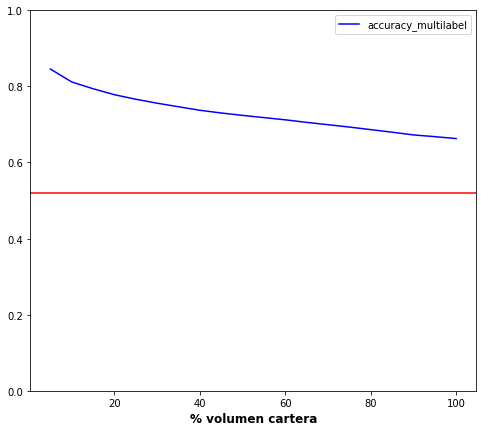

In [38]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(8,7))

font={'fontsize':12, 'fontweight': 'bold'}

#ax.plot(df.toPandas()['% volumen cartera'], df.toPandas()['accuracy'],color='blue')
ax.plot(df.toPandas()['% volumen cartera'], df.toPandas()['accuracy_multilabel'],color='blue')

#Calculo  accuracy baseline: count real_label_contain_1/ count total volume nif production
#plt.axhline(y=0.28, color='r', linestyle='-')

#Calculo accuracy baseline multilabel: count real_label_contain_1 + real_label_contain_2/ count total volume nif production
plt.axhline(y=0.52, color='r', linestyle='-')

ax.set_ylim([0.0,1])

ax.set_xlabel("% volumen cartera", fontdict = font)
ax.legend(loc='best')